In [8]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle, get_ece
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd
import timeit

### Visualize the data

<AxesSubplot: >

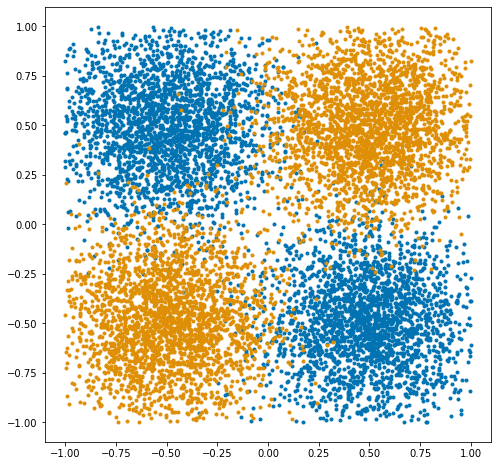

In [9]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

In [10]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [11]:
# network architecture [1000, 1000, 1000, 1000, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [12]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

2023-08-31 01:16:00.534513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping


### Calculate posteriors and likelihoods using KDN

In [ ]:
df = {}

t_0 = timeit.default_timer()
model_kdn = kdn(network=nn)
model_kdn.fit(X, y, k=2e8)
t_1 = timeit.default_timer()

print(f"Elapsed time: {t_1-t_0} s")

#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod = likelihoods_kdn_geod[:,1].reshape(400,400)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod'] = class1_likelihoods_geod
df['likelihood_class2_geod'] = class2_likelihoods_geod

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Elapsed time: 112.48411958300039 s
  81/5000 [..............................] - ETA: 9s

2023-08-31 01:18:17.228211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 9s 2ms/step
Unexpected exception formatting exception. Falling back to standard exception
Unexpected exception formatting exception. Falling back to standard exception


--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
--- Logging error ---
Error in sys.excepthook:
Traceback (most recent call last):
  File "/Users/jayantadey/miniforge3/envs/env/lib/python3.9/linecache.py", line 93, in updatecache
    stat = os.stat(fullname)
NotADirectoryError: [Errno 20] Not a directory: '/Users/jayantadey/miniforge3/envs/env/lib/python3.9/site-packages/kdg-0.0.1-py3.9.egg/kdg/kdn.py'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jayantadey/miniforge3/envs/env/lib/python3.9/linecache.py", line 46, in getlines
    return updatecache(filename, module_globals)
  File "/Users/jayantadey/miniforge3/envs/env/lib/python3.9/linecache.py", line 101, in updatecache
    data = cache[filename][0]()
  File "<frozen zipimport>", line 217, in get_source
  File "<frozen zipimport>", line 571, in _get_data
zlib.error: Error -5 while decompressing data: incomplete or truncat

In [ ]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[100:300, 100:300] = 1 - tmp
#df["true_proba"] = proba_true

In [ ]:
fig1, ax = plt.subplots(1, 4, figsize=(30, 150))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    1-posterior_rf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("RF Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    1-posterior_kdf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDF-Euclidean Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    1-posterior_kdf_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDF-Geodesic Class Posteriors", fontsize=24)
ax[3].set_aspect("equal")
plt.show()

### Visualize class likelihoods

In [ ]:
fig1, ax = plt.subplots(1, 4, figsize=(32, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods (Euclidean)", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods (Euclidean)", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    class1_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("Class 1 Likelihoods (Geodesic)", fontsize=24)
ax[2].set_aspect("equal")

ax3 = ax[3].imshow(
    class2_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("Class 2 Likelihoods (Geodesic)", fontsize=24)
ax[3].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [ ]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/sinewave_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((true_posterior.ravel(), 1-true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_sinewave(sample)
    X_test, y_test = generate_sinewave(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y, k=1e10)

    error_kdf = 1 - np.mean(model_kdf.predict(X_test)==y_test)
    error_kdf_geod = 1 - np.mean(model_kdf.predict(X_test, distance='Geodesic')==y_test)
    error_rf = 1 - np.mean(model_kdf.rf_model.predict(X_test)==y_test)
    
    proba_kdf = model_kdf.predict_proba(grid_samples)
    proba_kdf_geod = model_kdf.predict_proba(grid_samples, distance='Geodesic')
    proba_rf = model_kdf.rf_model.predict_proba(grid_samples)
    
    hellinger_dis_kdf = hellinger(true_posterior, proba_kdf)
    hellinger_dis_kdf_geod = hellinger(true_posterior, proba_kdf_geod)
    hellinger_dis_rf = hellinger(true_posterior, proba_rf)
    
    
    return error_kdf, error_kdf_geod, error_rf, hellinger_dis_kdf, hellinger_dis_kdf_geod, hellinger_dis_rf

def experiment_out(in_sample, r, n_test):
    X, y = generate_sinewave(in_sample)
    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y, k=1e3)

    X_ood = sample_unifrom_circle(n=n_test, r=r)
    mmcOut_rf = np.mean(np.max(model_kdf.rf_model.predict_proba(X_ood), axis=1))
    mmcOut_kdf = np.mean(np.max(model_kdf.predict_proba(X_ood), axis=1))
    mmcOut_kdf_geod = np.mean(np.max(model_kdf.predict_proba(X_ood, distance='Geodesic'), axis=1))
    mmcOut_tree = np.mean(np.max(model_kdf.rf_model.estimators_[0].predict_proba(X_ood), axis=1))
    
    return mmcOut_kdf, mmcOut_kdf_geod, mmcOut_rf
        
    
error_kdf_med = []
error_kdf_25 = []
error_kdf_75 = []
error_kdf_geod_med = []
error_kdf_geod_25 = []
error_kdf_geod_75 = []
error_rf_med = []
error_rf_25 = []
error_rf_75 = []

hellinger_kdf_med = []
hellinger_kdf_25 = []
hellinger_kdf_75 = []
hellinger_kdf_geod_med = []
hellinger_kdf_geod_25 = []
hellinger_kdf_geod_75 = []
hellinger_rf_med = []
hellinger_rf_25 = []
hellinger_rf_75 = []


mmcOut_kdf_med = []
mmcOut_kdf_25 = []
mmcOut_kdf_75 = []
mmcOut_kdf_geod_med = []
mmcOut_kdf_geod_25 = []
mmcOut_kdf_geod_75 = []
mmcOut_rf_med = []
mmcOut_rf_25 = []
mmcOut_rf_75 = []


#### do out-of-distribution results ####
for r in np.arange(0,10.5,.5):
    mmcOut_kdf = []
    mmcOut_rf = []
    mmcOut_kdf_geod = []
    
    res = Parallel(n_jobs=-1)(
            delayed(experiment_out)(
                    1000,
                    r,
                    n_test
                    ) for _ in range(mc_reps)
                )
    
    for ii in range(mc_reps):
        mmcOut_kdf.append(res[ii][0])
        mmcOut_kdf_geod.append(res[ii][1])
        mmcOut_rf.append(res[ii][2])
        
    
    
    mmcOut_kdf_med.append(
        np.median(mmcOut_kdf)
    )
    mmcOut_kdf_25.append(
        np.quantile(mmcOut_kdf, [0.25])[0]
    )
    mmcOut_kdf_75.append(
        np.quantile(mmcOut_kdf, [0.75])[0]
    )
    
    mmcOut_kdf_geod_med.append(
        np.median(mmcOut_kdf)
    )
    mmcOut_kdf_geod_25.append(
        np.quantile(mmcOut_kdf, [0.25])[0]
    )
    mmcOut_kdf_geod_75.append(
        np.quantile(mmcOut_kdf, [0.75])[0]
    )
    
    mmcOut_rf_med.append(
        np.median(mmcOut_rf)
    )
    mmcOut_rf_25.append(
        np.quantile(mmcOut_rf, [0.25])[0]
    )
    mmcOut_rf_75.append(
        np.quantile(mmcOut_rf, [0.75])[0]
    )
    
        
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdf = []
    err_kdf_geod = []
    err_rf = []
    hellinger_kdf = []
    hellinger_kdf_geod = []
    hellinger_rf = []
    
    for ii in range(mc_reps):
        err_kdf.append(res[ii][0])
        err_kdf_geod.append(res[ii][1])
        err_rf.append(res[ii][2])
        hellinger_kdf.append(res[ii][3])
        hellinger_kdf_geod.append(res[ii][4])
        hellinger_rf.append(res[ii][5])
        

    error_kdf_med.append(
        np.median(err_kdf)
    )
    error_kdf_25.append(
        np.quantile(err_kdf, [0.25])[0]
    )
    error_kdf_75.append(
        np.quantile(err_kdf, [0.75])[0]
    )
    
    error_kdf_geod_med.append(
        np.median(err_kdf)
    )
    error_kdf_geod_25.append(
        np.quantile(err_kdf, [0.25])[0]
    )
    error_kdf_geod_75.append(
        np.quantile(err_kdf, [0.75])[0]
    )
    
    error_rf_med.append(
        np.median(err_rf)
    )
    error_rf_25.append(
        np.quantile(err_rf, [0.25])[0]
    )
    error_rf_75.append(
        np.quantile(err_rf, [0.75])[0]
    )
    
    
    hellinger_kdf_med.append(
        np.median(hellinger_kdf)
    )
    hellinger_kdf_25.append(
        np.quantile(hellinger_kdf, [0.25])[0]
    )
    hellinger_kdf_75.append(
        np.quantile(hellinger_kdf, [0.75])[0]
    )
    
    hellinger_kdf_geod_med.append(
        np.median(hellinger_kdf_geod)
    )
    hellinger_kdf_geod_25.append(
        np.quantile(hellinger_kdf_geod, [0.25])[0]
    )
    hellinger_kdf_geod_75.append(
        np.quantile(hellinger_kdf_geod, [0.75])[0]
    )
    
    hellinger_rf_med.append(
        np.median(hellinger_rf)
    )
    hellinger_rf_25.append(
        np.quantile(hellinger_rf, [0.25])[0]
    )
    hellinger_rf_75.append(
        np.quantile(hellinger_rf, [0.75])[0]
    )
    
    

df['error_kdf_med'] = error_kdf_med
df['error_kdf_25'] = error_kdf_25
df['error_kdf_75'] = error_kdf_75

df['error_kdf_geod_med'] = error_kdf_geod_med
df['error_kdf_geod_25'] = error_kdf_geod_25
df['error_kdf_geod_75'] = error_kdf_geod_75

df['error_rf_med'] = error_rf_med
df['error_rf_25'] = error_rf_25
df['error_rf_75'] = error_rf_75

df['hellinger_kdf_med'] = hellinger_kdf_med
df['hellinger_kdf_25'] = hellinger_kdf_25
df['hellinger_kdf_75'] = hellinger_kdf_75

df['hellinger_kdf_geod_med'] = hellinger_kdf_geod_med
df['hellinger_kdf_geod_25'] = hellinger_kdf_geod_25
df['hellinger_kdf_geod_75'] = hellinger_kdf_geod_75

df['hellinger_rf_med'] = hellinger_rf_med
df['hellinger_rf_25'] = hellinger_rf_25
df['hellinger_rf_75'] = hellinger_rf_75

df['mmcOut_kdf_med'] = mmcOut_kdf_med
df['mmcOut_kdf_25'] = mmcOut_kdf_25
df['mmcOut_kdf_75'] = mmcOut_kdf_75

df['mmcOut_kdf_geod_med'] = mmcOut_kdf_geod_med
df['mmcOut_kdf_geod_25'] = mmcOut_kdf_geod_25
df['mmcOut_kdf_geod_75'] = mmcOut_kdf_geod_75

df['mmcOut_rf_med'] = mmcOut_rf_med
df['mmcOut_rf_25'] = mmcOut_rf_25
df['mmcOut_rf_75'] = mmcOut_rf_75

In [5]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=2e8)
    
    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    
    proba_dn = model_kdn.network.predict(X_test)
    proba_kdn = model_kdn.predict_proba(X_test)
    predicted_label_dn = np.argmax(proba_dn,axis=1)
    predicted_label_kdn = np.argmax(proba_kdn, axis=1)
    error_kdn = 1 - np.mean(predicted_label_kdn==y_test)   
    error_dn = 1 - np.mean(predicted_label_dn==y_test)
    ece_dn = get_ece(proba_dn, predicted_label_dn, y_test)
    ece_kdn = get_ece(proba_kdn, predicted_label_kdn, y_test)
    
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_dn = model_kdn.network.predict(grid_samples)
    hellinger_dis_kdn = hellinger(1-true_posterior, proba_kdn)
    hellinger_dis_dn = hellinger(1-true_posterior, proba_dn)
    mmcIn_dn = np.mean(np.max(proba_dn, axis=1)) 
    mmcIn_kdn = np.mean(np.max(proba_kdn, axis=1))
    
    return error_kdn, error_dn, hellinger_dis_kdn, hellinger_dis_dn, mmcIn_kdn, mmcIn_dn, ece_kdn, ece_dn

def experiment_out(in_sample, r, n_test):
    mmcOut_dn = np.zeros(len(r),dtype=float)
    mmcOut_kdn = np.zeros(len(r),dtype=float)
    
    X, y = generate_gaussian_parity(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e3)
    
    for ii, r_ in enumerate(r):
        X_ood = sample_unifrom_circle(n=n_test, r=r_)
        mmcOut_dn[ii] = np.mean(np.max(
            model_kdn.network.predict(X_ood), axis=1
            )
        )
        mmcOut_kdn[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
    
    return mmcOut_kdn, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []
ece_kdn_med = []
ece_kdn_25 = []
ece_kdn_75 = []
ece_dn_med = []
ece_dn_25 = []
ece_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []

mmcIn_kdn_med = []
mmcIn_kdn_25 = []
mmcIn_kdn_75 = []
mmcIn_dn_med = []
mmcIn_dn_25 = []
mmcIn_dn_75 = []

mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []

#### do out-of-distribution results ####
r = np.arange(0,10.5,.5)
mmcOut_kdn = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_dn = np.zeros((len(r),mc_reps), dtype=float)

for rep in range(mc_reps):
    mmcOut_kdn[:,rep], mmcOut_dn[:,rep] = experiment_out(1000, r, n_test)
    
    
    
mmcOut_kdn_med = np.median(mmcOut_kdn, axis=1)
mmcOut_kdn_25 = np.quantile(mmcOut_kdn, [0.25], axis=1)
mmcOut_kdn_75 = np.quantile(mmcOut_kdn, [0.75], axis=1)
    
mmcOut_dn_med = np.median(mmcOut_dn, axis=1)
mmcOut_dn_25 = np.quantile(mmcOut_dn, [0.25], axis=1)
mmcOut_dn_75 = np.quantile(mmcOut_dn, [0.75], axis=1)
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdn = []
    err_dn = []
    hellinger_kdn = []
    hellinger_dn = []
    mmcIn_kdn = []
    mmcIn_dn = []
    ece_kdn = []
    ece_dn = []
    for ii in range(mc_reps):
        err_kdn.append(res[ii][0])
        err_dn.append(res[ii][1])
        hellinger_kdn.append(res[ii][2])
        hellinger_dn.append(res[ii][3])
        mmcIn_kdn.append(res[ii][4])
        mmcIn_dn.append(res[ii][5])
        ece_kdn.append(res[ii][6])
        ece_dn.append(res[ii][7])

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )

    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    ece_dn_med.append(
        np.median(ece_dn)
    )
    ece_dn_25.append(
        np.quantile(ece_dn, [0.25])[0]
    )
    ece_dn_75.append(
        np.quantile(ece_dn, [0.75])[0]
    )
    
    ece_kdn_med.append(
        np.median(ece_kdn)
    )
    ece_kdn_25.append(
        np.quantile(ece_kdn, [0.25])[0]
    )
    ece_kdn_75.append(
        np.quantile(ece_kdn, [0.75])[0]
    )
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )

    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )

    mmcIn_kdn_med.append(
        np.median(mmcIn_kdn)
    )
    mmcIn_kdn_25.append(
        np.quantile(mmcIn_kdn, [0.25])[0]
    )
    mmcIn_kdn_75.append(
        np.quantile(mmcIn_kdn, [0.75])[0]
    )

    mmcIn_dn_med.append(
        np.median(mmcIn_dn)
    )
    mmcIn_dn_25.append(
        np.quantile(mmcIn_dn, [0.25])[0]
    )
    mmcIn_dn_75.append(
        np.quantile(mmcIn_dn, [0.75])[0]
    )


df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['ece_dn_med'] = ece_dn_med
df['ece_dn_25'] = ece_dn_25
df['ece_dn_75'] = ece_dn_75

df['ece_kdn_med'] = ece_kdn_med
df['ece_kdn_25'] = ece_kdn_25
df['ece_kdn_75'] = ece_kdn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcIn_kdn_med'] = mmcIn_kdn_med
df['mmcIn_kdn_25'] = mmcIn_kdn_25
df['mmcIn_kdn_75'] = mmcIn_kdn_75

df['mmcIn_dn_med'] = mmcIn_dn_med
df['mmcIn_dn_25'] = mmcIn_dn_25
df['mmcIn_dn_75'] = mmcIn_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25.reshape(-1)
df['mmcOut_kdn_75'] = mmcOut_kdn_75.reshape(-1)

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25.reshape(-1)
df['mmcOut_dn_75'] = mmcOut_dn_75.reshape(-1)

Metal device set to: Apple M1 Max


2023-05-14 13:43:52.943362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-14 13:43:52.943514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-14 13:43:53.132680: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-14 13:43:53.261936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-05-14 13:43:55.078574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:43:58.383805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:00.082420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:03.471214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:05.208749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:08.359047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 89: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:09.231151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:12.401459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:14.132742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-05-14 13:44:17.531907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 131: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:18.722510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:21.909301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:23.622300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:26.949169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:28.741363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:32.128744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:33.901018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:37.240119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:44:37.696045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:41.137136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 164: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:43.900888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:47.122623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:47.789561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:50.883093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:44:54.008207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:44:57.129748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:00.263289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:03.460120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:04.495623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:07.686347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 153: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:10.229598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:13.363426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-05-14 13:45:16.572411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:19.758233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 115: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:21.758975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:24.826961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 141: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:45:27.273493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:30.356282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 164: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:33.061619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:36.583602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 125: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:44.829643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:48.145315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 100: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:45:55.067852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:45:58.385028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 103: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:05.536529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:08.845080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 57: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:13.574024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:16.891770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 113: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:24.526500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:27.853580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:46:31.723376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:35.035539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 70: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:40.455994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:43.796206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:46:47.643609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:46:51.020595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:46:56.981549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:00.293214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 101: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:47:07.363071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:10.780622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 124: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:47:29.603506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:33.568281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:47:42.804915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:46.417085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 17: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 13:47:54.191706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:47:57.825927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 80: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:48:12.120010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:48:15.776966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:48:27.382973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:48:31.114496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 113: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:48:48.841315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:48:52.494674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 102: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:49:09.024901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:49:12.655246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:49:21.057498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:49:24.736244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:49:37.710290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:49:41.353101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:49:54.439967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:49:58.131963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:52:31.265104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:52:37.259756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:55:09.021998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:55:15.442974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 63: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 13:57:58.272005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 13:58:04.425862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 84: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:13:40.590305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:13:47.030442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 75: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:16:34.306023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:16:40.491547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 68: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:19:24.098320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:19:30.305484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:21:53.678449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:21:59.797983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 99: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:24:58.230794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:25:04.524278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:27:43.063286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:27:49.161399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:30:21.613053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:30:27.508915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:40:32.396143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:40:41.548202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 14:50:41.913234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 14:50:51.093694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:00:54.040045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:01:03.657211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:11:14.461909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-05-14 15:11:24.387463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 167: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:23:33.458381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:23:42.585471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:33:45.174488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:33:54.292359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:44:04.824045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:44:13.443290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 148: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 15:55:54.398512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 15:56:03.228196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 167: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 16:08:02.635974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 16:08:11.463702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 16:18:59.341697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


"df['mmcOut_kdn_med'] = mmcOut_kdn_med\ndf['mmcOut_kdn_25'] = mmcOut_kdn_25.reshape(-1)\ndf['mmcOut_kdn_75'] = mmcOut_kdn_75.reshape(-1)\n\ndf['mmcOut_dn_med'] = mmcOut_dn_med\ndf['mmcOut_dn_25'] = mmcOut_dn_25.reshape(-1)\ndf['mmcOut_dn_75'] = mmcOut_dn_75.reshape(-1)"

### Save the result

In [7]:
import pickle
filename = 'results/gxor.pickle'

with open(filename, 'wb') as f:
    pickle.dump(df,f)

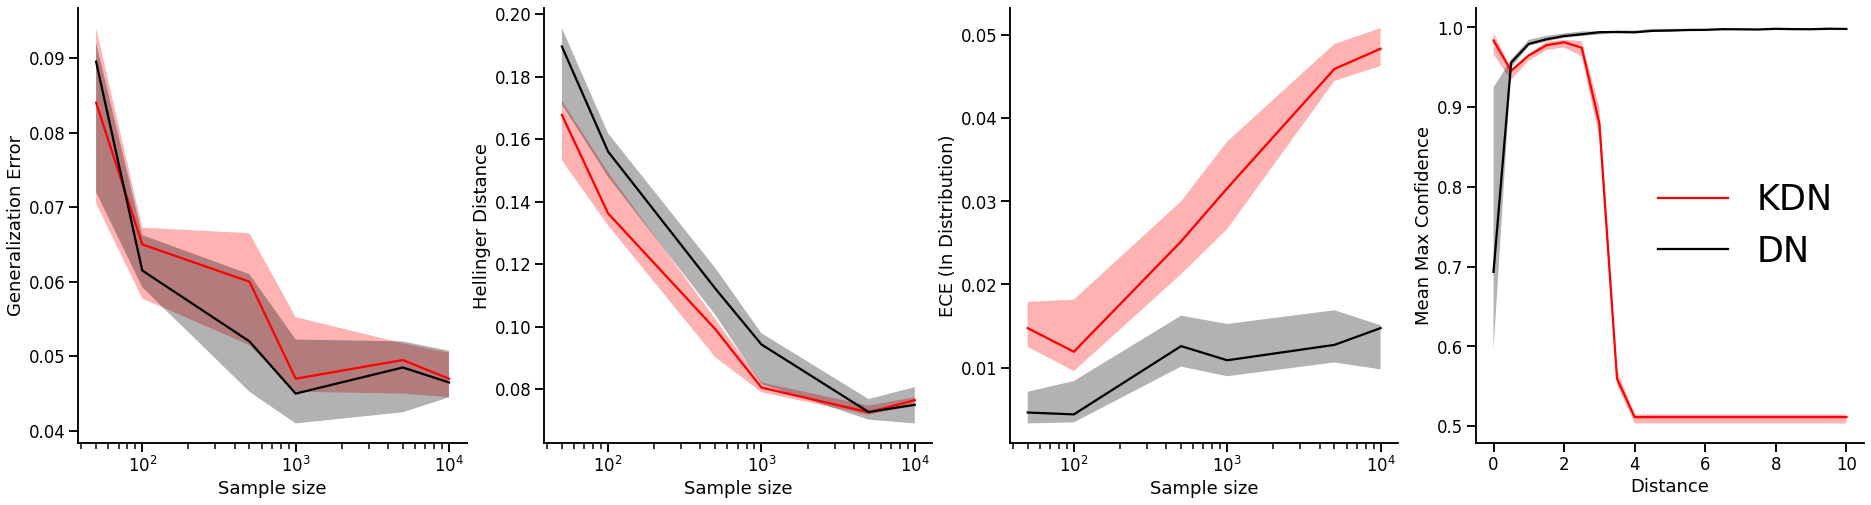

In [6]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['ece_kdn_med'], c="r", label='KDN')
ax[2].plot(sample_size, df['ece_dn_med'], c="k", label='DN')
#ax[2].plot(sample_size, df['mmcIn_tree_med'], c="b", label='DT')

ax[2].fill_between(sample_size, df['ece_kdn_25'], df['ece_kdn_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['ece_dn_25'], df['ece_dn_75'], facecolor='k', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('ECE (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN')
ax[3].plot(r, df['mmcOut_dn_med'], c="k", label='DN')

ax[3].fill_between(r, df['mmcOut_kdn_25'], df['mmcOut_kdn_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df['mmcOut_dn_25'], df['mmcOut_dn_75'], facecolor='k', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [78]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [79]:
sample = 1000
reps = 10
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_dn = []
roc_kdn = []

fpr_dn = []
fpr_kdn = []
reps_list = []

for ii in range(reps):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=1, network=nn)
    model_kdn.fit(X, y)

    dn_in_conf = np.max(model_kdn.network.predict(X_test), axis=1)
    dn_out_conf = np.max(model_kdn.network.predict(X_ood), axis=1)
    dn_conf = np.hstack((dn_in_conf, dn_out_conf))
    roc_dn.append(
        roc_auc_score(true_labels, dn_conf)
    )
    fpr_dn.append(
        fpr_at_95_tpr(dn_in_conf, dn_out_conf)
    )
    
    

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

2023-03-06 09:26:59.365859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 129: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.98it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 09:29:19.360454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:29:19.846879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.01it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 09:31:31.755608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:31:32.253041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:41<00:00,  1.12s/it]


 1/32 [..............................] - ETA: 2s

2023-03-06 09:50:17.663610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:50:18.167306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [23:45<00:00,  1.43s/it]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:14:14.191732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:14:14.710628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.16it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:16:26.411805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:16:26.905171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.83it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:18:41.104489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:18:41.582798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 114: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.93it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:21:01.282403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:21:01.783859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.06it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:23:10.871671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:23:11.402165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.03it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:25:23.137776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:25:23.632406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.84it/s]


 1/32 [..............................] - ETA: 2s

2023-03-06 10:27:35.285419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


In [80]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdn), np.std(roc_kdn)))
print("DN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_dn), np.std(roc_dn)))

KDN AUROC = 0.955 +/- 0.003
DN AUROC = 0.324 +/- 0.074


In [81]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdn), np.std(fpr_kdn)))
print("DN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_dn), np.std(fpr_dn)))

KDN FPR@95 = 0.504 +/- 0.356
DN FPR@95 = 0.910 +/- 0.081
